<a href="https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/PBR_materials_NN_compression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage
import urllib.request
import jax
import jax.numpy as jnp
from zipfile import ZipFile

Load a material from a zip file.

In [2]:
urllib.request.urlretrieve('https://www.dropbox.com/s/h2jir69q1ipk09o/PavingStones054_2K-JPG.zip?dl=1', filename='zip.zip')
texture_names = []
with ZipFile('zip.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
   texture_names = zipObj.namelist()

Data preprocessing - load the textures, convert the grayscale ones to a single channel, and concatenate them along "channel" axis.
Keep the original indices referring to which channel corresponds to which texture index and name.


In [3]:
all_pbr_channels_concat = None
orig_tex_indices = []
init = False
for tex_name in texture_names:
  test_img = cv2.imread(tex_name)[:,:,(2,1,0)] / 255.0
  test_img_copy = test_img.copy()
  # simple stupid test if it's grayscale~ish
  if np.mean(test_img[:,:,0]-test_img[:,:,1]) < 0.0001:
    test_img = test_img[:,:,[0]]
  if not init:
    init = True
    all_pbr_channels_concat = test_img.copy()
    orig_tex_indices.append((0, test_img.shape[2], tex_name))
  else:
    print(all_pbr_channels_concat.shape, test_img.shape)
    orig_tex_indices.append((orig_tex_indices[-1][1], orig_tex_indices[-1][1] + test_img.shape[2], tex_name))
    all_pbr_channels_concat = np.concatenate((all_pbr_channels_concat, test_img), axis=2)
print(orig_tex_indices)
print(all_pbr_channels_concat.shape)

(2048, 1365, 1) (2048, 1365, 3)
(2048, 1365, 4) (2048, 1365, 1)
(2048, 1365, 5) (2048, 1365, 3)
(2048, 1365, 8) (2048, 1365, 1)
[(0, 1, 'PavingStones054_2K_AmbientOcclusion.jpg'), (1, 4, 'PavingStones054_2K_Color.jpg'), (4, 5, 'PavingStones054_2K_Displacement.jpg'), (5, 8, 'PavingStones054_2K_Normal.jpg'), (8, 9, 'PavingStones054_2K_Roughness.jpg')]
(2048, 1365, 9)


Function for "unconcatenating" and displaying the material.

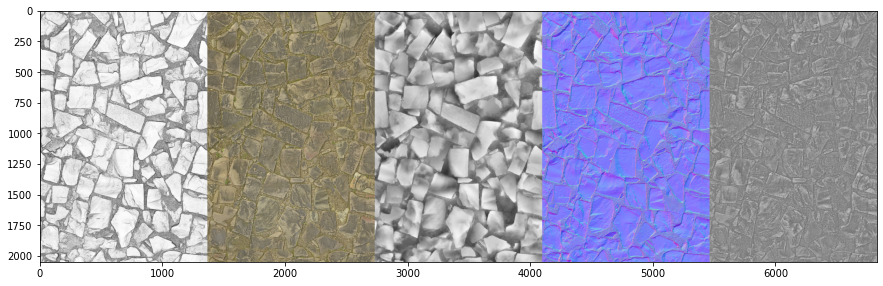

In [4]:
def display_from_concat(x):
  recons_stacked = None
  for i,l in enumerate(orig_tex_indices):
    slice = x[:,:,l[0]:l[1]]
    if (l[1] - l[0] == 1):
      slice = slice[:,:,[0,0,0]]
    if i == 0:
      recons_stacked = slice.copy()
    else:
      recons_stacked = np.concatenate((recons_stacked,slice), axis=1)
  return recons_stacked

plt.rcParams['figure.figsize']=15,15
plt.imshow(display_from_concat(all_pbr_channels_concat))

Flatten/unflatten to SVD or NN friendly representation.

In [5]:
def flatten(x):
  return x.reshape(all_pbr_channels_concat.shape[0]*all_pbr_channels_concat.shape[1],all_pbr_channels_concat.shape[2])
def unflatten(x):
  return x.reshape(all_pbr_channels_concat.shape[0],all_pbr_channels_concat.shape[1],all_pbr_channels_concat.shape[2])
def unflatten2(x):
  return x.reshape(all_pbr_channels_concat.shape[0],all_pbr_channels_concat.shape[1],x.shape[1])


PSNR helper function.

In [6]:
def psnr(img1, img2, w = None):
  mse = np.mean( (img1 - img2) ** 2 )
  if mse == 0:
    return 100
  return -10 * np.log10(mse)

psnr(flatten(all_pbr_channels_concat), np.mean(flatten(all_pbr_channels_concat),axis=0))

18.012281764318697

In [18]:
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import GeneralConv, Conv, Dense, FanOut, Relu, Softplus, Sigmoid

decoder_init, decode = stax.serial(
    Dense(64), Relu,
    Dense(all_pbr_channels_concat.shape[2]), Sigmoid
)

learning_rate = 1e-2
num_c = 3 # number of stored channels
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
input_shape = (1, all_pbr_channels_concat.shape[0], all_pbr_channels_concat.shape[1], num_c)
print(input_shape)

_, init_decoder_params = decoder_init(jax.random.PRNGKey(2), input_shape)

flat = jax.device_put(all_pbr_channels_concat)

@jax.jit
def loss(params):
  return jnp.mean(jnp.square(decode(params[1], params[0])[0] - flat))

@jax.jit
def update(i, opt_state):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params), opt_state)

# First tuple element is the texture / latent code, second is the decoder weights.
opt_state = opt_init((jnp.zeros((1, all_pbr_channels_concat.shape[0], all_pbr_channels_concat.shape[1], num_c)), init_decoder_params))
num_steps = 5000
for i in range(num_steps+1):
  opt_state = update(i, opt_state)
  if (i % 200) == 0:
    print(i*100//num_steps, -10.0 * jnp.log10(loss(get_params(opt_state))), '\r')


(1, 2048, 1365, 3)
0 12.894406 
4 29.08756 
8 30.609941 
12 31.09201 
16 31.281437 
20 31.399776 
24 31.484653 
28 31.56036 
32 31.590845 
36 31.739151 
40 31.80748 
44 31.86655 
48 31.916945 
52 31.997643 
56 32.07455 
60 32.065536 
64 32.163017 
68 32.1933 
72 32.21768 
76 32.23746 
80 32.261223 
84 32.26371 
88 32.27854 
92 32.242245 
96 32.320168 
100 32.28415 


Display the latent code

(3, 64)


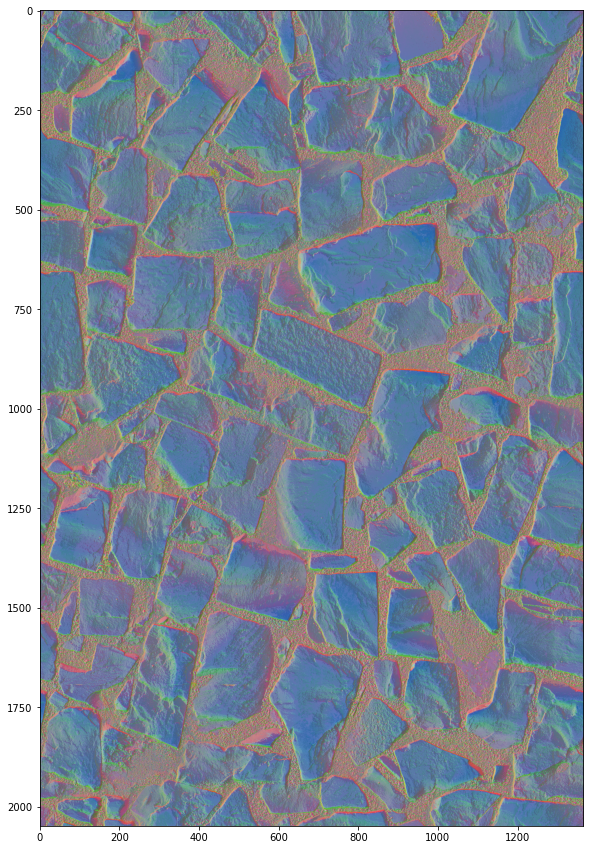

In [17]:
params = get_params(opt_state)
print(params[1][0][0].shape)
plt.imshow(jnp.clip(0.5 * params[0][0,...,0:3] + 0.5, 0, 1))